In [ ]:
!pip install mne==0.17.1

     |████████████████████████████████| 6.2MB 8.3MB/s 
  Created wheel for mne: filename=mne-0.17.1-cp36-none-any.whl size=6194555 sha256=525f7d6f7deda890d2c2c6fa36f85f92eeb741ad7bcf3fff11da53a7fa5e5704
  Stored in directory: /root/.cache/pip/wheels/39/f9/f5/3e2fdef321f8e1f64061730c8ba2c81ad55c4b1b860b29d2dd
Successfully built mne


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
% cd "/content/drive/My Drive/"

Mounted at /content/drive
/content/drive/My Drive


In [ ]:
import mne
%matplotlib inline
import numpy as np

# Mention the file path to the dataset
filename = "/content/drive/My Drive/BCICIV_2a_gdf/A09T.gdf"

raw = mne.io.read_raw_edf(filename)

print(raw.info)
print(raw.ch_names)

Extracting EDF parameters from /content/drive/My Drive/BCICIV_2a_gdf/A09T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | EEG-Fz, EEG-0, EEG-1, EEG-2, EEG-3, EEG-4, EEG-5, ...
    chs : list | 26 items (EEG: 25, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.5 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 100.0 Hz
    meas_date : tuple | 2004-11-16 12:00:00 GMT
    nchan : int | 26
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 250.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : None

/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1086: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
<ipython-input-158-9f8e4c005550>:8: RuntimeWarning: Overlapping events detected. Use find_edf_events for the original events.
  raw = mne.io.read_raw_edf(filename)
<ipython-input-158-9f8e4c005550>:8: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw = mne.io.read_raw_edf(filename)
<ipython-input-158-9f8e4c005550>:8: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(filename)


In [ ]:
  

# Find the events time positions
edf_events = mne.io.find_edf_events(raw)

# Change the event matrix to epoch readable format

events = (np.vstack((edf_events[1],edf_events[3],edf_events[2]))).T

# Pre-load the data

raw.load_data()

# Filter the raw signal with a band pass filter in 7-35 Hz

raw.filter(7., 30., fir_design='firwin')

# Remove the EOG channels and pick only desired EEG channels

raw.info['bads'] += ['EOG-left', 'EOG-central', 'EOG-right']

picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False,
                       exclude='bads')

# Extracts epochs of 3s time period from the datset into 288 events for all 4 classes

tmin, tmax = 1., 4.
event_id = dict(left_hand = 769,right_hand = 770,foot = 771,tongue = 772)

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)



Reading 0 ... 673327  =      0.000 ...  2693.308 secs...
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 413 samples (1.652 sec) selected
288 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 288 events and 751 original time points ...
0 bad epochs dropped


<Evoked  |  'left_hand' (mean, N=72), [1, 4] sec, 22 ch, ~173 kB>


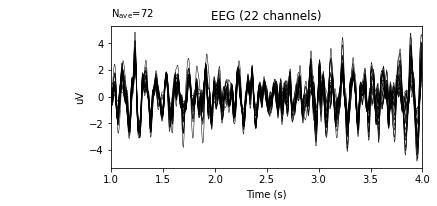

<Evoked  |  'right_hand' (mean, N=72), [1, 4] sec, 22 ch, ~173 kB>


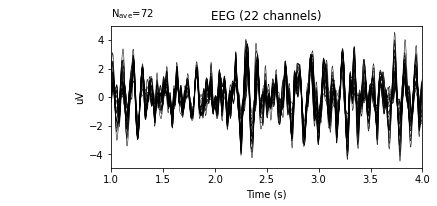

<Evoked  |  'foot' (mean, N=72), [1, 4] sec, 22 ch, ~173 kB>


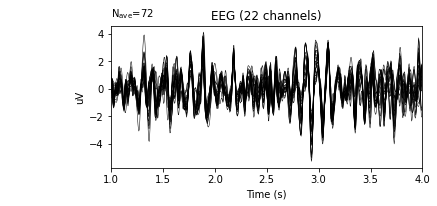

<Evoked  |  'tongue' (mean, N=72), [1, 4] sec, 22 ch, ~173 kB>


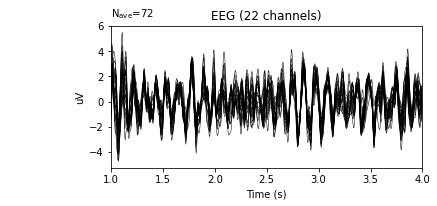

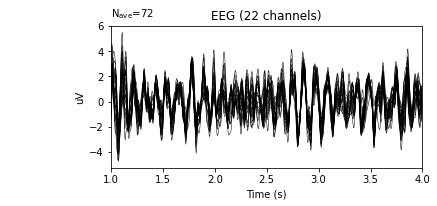

In [ ]:
# Left hand epoch average plot

evoked = epochs['left_hand'].average()
print(evoked)
evoked.plot(time_unit='s')

# Right hand epoch average plot

evoked = epochs['right_hand'].average()
print(evoked)
evoked.plot(time_unit='s')

# Foot epoch average plot

evoked = epochs['foot'].average()
print(evoked)
evoked.plot(time_unit='s')

# Tongue epoch average plot

evoked = epochs['tongue'].average()
print(evoked)
evoked.plot(time_unit='s')

In [ ]:
labels = epochs.events[:,-1] - 769 + 1

data = epochs.get_data()

In [ ]:
import pywt

# signal is decomposed to level 5 with 'db4' wavelet

def wpd(X): 
    coeffs = pywt.WaveletPacket(X,'db4',mode='symmetric',maxlevel=5)
    return coeffs
             
def feature_bands(x):
    
    Bands = np.empty((8,x.shape[0],x.shape[1],30)) # 8 freq band coefficients are chosen from the range 4-32Hz
    
    for i in range(x.shape[0]):
        for ii in range(x.shape[1]):
             pos = []
             C = wpd(x[i,ii,:]) 
             pos = np.append(pos,[node.path for node in C.get_level(5, 'natural')])
             for b in range(1,9):
                 Bands[b-1,i,ii,:] = C[pos[b]].data
        
    return Bands

wpd_data = feature_bands(data)

In [ ]:
from mne.decoding import CSP # Common Spatial Pattern Filtering
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from sklearn.model_selection import ShuffleSplit

# OneHotEncoding Labels
enc = OneHotEncoder()
X_out = enc.fit_transform(labels.reshape(-1,1)).toarray()

# Cross Validation Split
cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

acc = []
ka = []
prec = []
recall = []

In [ ]:
for train_idx, test_idx in cv.split(labels):
    
    Csp = [];ss = [];nn = [] # empty lists
    
    label_train, label_test = labels[train_idx], labels[test_idx]
    y_train, y_test = X_out[train_idx], X_out[test_idx]
    
    # CSP filter applied separately for all Frequency band coefficients
    
    Csp = [CSP(n_components=4, reg=None, log=True, norm_trace=False) for _ in range(8)]
    ss = preprocessing.StandardScaler()

    X_train = ss.fit_transform(np.concatenate(tuple(Csp[x].fit_transform(wpd_data[x,train_idx,:,:],label_train) for x  in range(8)),axis=-1))

    X_test = ss.transform(np.concatenate(tuple(Csp[x].transform(wpd_data[x,test_idx,:,:]) for x  in range(8)),axis=-1))
    
    # nn = build_classifier()  
    
    # nn.fit(X_train, y_train, batch_size = 32, epochs = 200)
    
    # y_pred = nn.predict(X_test)
    # pred = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)

    # acc.append(accuracy_score(y_test.argmax(axis=1), pred.argmax(axis=1)))
    # ka.append(cohen_kappa_score(y_test.argmax(axis=1), pred.argmax(axis=1)))
    # prec.append(precision_score(y_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
    # recall.append(recall_score(y_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))

Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPI

In [ ]:
import keras
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import AveragePooling1D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings

In [ ]:
X_train.shape

(230, 32)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
X_train.shape

(230, 32, 1)

In [ ]:
!pip install Merge

In [ ]:
import keras
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import Concatenate , Activation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings

In [ ]:
from keras.layers.recurrent import LSTM

model1 = Sequential()

model1.add(Conv1D(32, (3), activation='elu', input_shape=(32,1)))
model1.add(MaxPooling1D(pool_size=(1)))

model1.add(Conv1D(64, (3), activation='elu'))
model1.add(MaxPooling1D(pool_size=(1)))

model1.add(Conv1D(128, (3), activation='elu'))
model1.add(MaxPooling1D(pool_size=(1)))

model1.add(Conv1D(256, (3), activation='elu'))
model1.add(MaxPooling1D(pool_size=(1)))

model1.add(Conv1D(512, (3), activation='elu'))
model1.add(MaxPooling1D(pool_size=(1)))

model1.add(Conv1D(1024, (3), activation='elu'))
model1.add(MaxPooling1D(pool_size=(1)))

model1.add(Flatten())
model1.add(Dense(1024, activation='elu'))
model1.add(Dense(512, activation='elu'))
model1.add(Dense(256, activation='elu'))
model1.add(Dense(128, activation='elu'))
model1.add(Dense(64, activation='elu'))
model1.add(Dense(4, activation='softmax'))



model2 = Sequential()

model2.add(Conv1D(32, (3), activation='elu', input_shape=(32,1)))
model2.add(MaxPooling1D(pool_size=(1)))

model2.add(Conv1D(64, (3), activation='elu'))
model2.add(MaxPooling1D(pool_size=(1)))

model2.add(Conv1D(128, (3), activation='elu'))
model2.add(MaxPooling1D(pool_size=(1)))

model2.add(Conv1D(256, (3), activation='elu'))
model2.add(MaxPooling1D(pool_size=(1)))
model2.add(LSTM(256))

model2.add(Flatten())

model2.add(Dense(128, activation='elu'))
model2.add(Dense(64, activation='elu'))
model2.add(Dense(4, activation='softmax')) 


merged = Concatenate()([model1.output,model2.output])
#z = Dense(128, activation="relu")(merged)
#z2 = Dropout(0.25)(z)
#z3 = Dense(1024, activation="relu")(z2)
#z4 = Dense(4, activation="softmax")(z3)
z4 = Dense(4, activation="softmax")(merged)
model = keras.Model(inputs=[model1.input, model2.input], outputs=z4)

model.compile(optimizer='ADAM',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_90_input (InputLayer)    [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_90 (Conv1D)              (None, 30, 32)       128         conv1d_90_input[0][0]            
__________________________________________________________________________________________________
max_pooling1d_90 (MaxPooling1D) (None, 30, 32)       0           conv1d_90[0][0]                  
__________________________________________________________________________________________________
conv1d_91 (Conv1D)              (None, 28, 64)       6208        max_pooling1d_90[0][0]           
____________________________________________________________________________________________

In [ ]:
model.fit(
    [X_train,
    X_train], 
    y_train,
    validation_data=([X_test,X_test], y_test),
    batch_size=16, epochs=1000, 
    )


Epoch 1/1000
15/15 [==============================] - 3s 59ms/step - loss: 1.2503 - accuracy: 0.3808 - val_loss: 1.2727 - val_accuracy: 0.3103
Epoch 2/1000
15/15 [==============================] - 0s 18ms/step - loss: 1.2421 - accuracy: 0.4013 - val_loss: 1.4408 - val_accuracy: 0.2586
Epoch 3/1000
15/15 [==============================] - 0s 16ms/step - loss: 1.3267 - accuracy: 0.2782 - val_loss: 1.4623 - val_accuracy: 0.2241
Epoch 4/1000
15/15 [==============================] - 0s 17ms/step - loss: 1.3485 - accuracy: 0.2804 - val_loss: 1.3776 - val_accuracy: 0.2586
Epoch 5/1000
15/15 [==============================] - 0s 17ms/step - loss: 1.2973 - accuracy: 0.3315 - val_loss: 1.3132 - val_accuracy: 0.2586
Epoch 6/1000
15/15 [==============================] - 0s 17ms/step - loss: 1.2559 - accuracy: 0.2815 - val_loss: 1.3269 - val_accuracy: 0.2069
Epoch 7/1000
15/15 [==============================] - 0s 17ms/step - loss: 1.2402 - accuracy: 0.2725 - val_loss: 1.3191 - val_accuracy: 0.3966